# Computational Guided Inquiry (Rowe & Neshyba, 2015)

## Optimal inverse retrieval of cloud properties 

**OBJECTIVE**: Build intuition and skill in retrieving atmospheric properties from remotely-sensed data

**SELF-ASSESSMENTS**:

1.	Define the terms _Planck blackbody function_ and _greybody model_.
2.  Sketch a greybody spectrum, and explain how it would change when temperature and emissivity are increased or decreased.
3.  Define and explain relationships between _observed quantities_, _quantities of interest_, and _forward models_ in the context of inverse retrieval, with examples.
4.  Describe complicating factors that inverse retrieval methods typically encounter.

## Introduction

It is often the case in atmospheric science that one would like to know some property of the atmosphere that is difficult to measure directly. For example, perhaps you'd like to know the temperature at a certain altitude, but you don't have an airplane to carry a thermometer to the necessary height. In such situations, one can fall back on indirect methods. One indirect method is called _inversion_: you remotely measure a quantity that _depends_ on the property you want, and from that you try to retrieve the property you are really interested in. Inverse retrieval is the focus of this exercise.  

At the heart of any inversion problem is something called the _forward model_, designated _f_. If we use _x_ to symbolize the property or properties we're interested in (we'll call these the _quantities of interest_), and _y_ to symbolize the remotely-sensed observations (call these the _observed quantities_), then the forward model is a function that lets us calculate _y_ from _x_. Mathematically, we'd write this as _y=f(x)_. The forward model is generally an approximation to real atmospheric processes, but we hope that it is a good enough replica of what goes on in the real world that we can get useful information using it.  

In fact, what we need is actually the inverse of the forward model: we need a way to calculate quantities of interest from observed quantities. Mathematically, we'd say we want $x=f^{-1}(y)$. Inversion is not always easy because of several complicating factors. First, there might be multiple quantities of interest (_x_) that are consistent with the observed quantities (_y_); then you have a non-unique inversion problem on your hands. Then there is the possibility that since the forward model is not an exact replica of what goes on in the real world, it could have systematic biases built in. And what if your observations are noisy? While there are multiple inverse retrieval algorithms available for accomplishing this, the one you'll learn about here is a powerful one that we'll call the _optimal inverse retrieval_ (see CD Rodgers, Inverse Methods for Atmospheric Sounding, 2000 (World Scientific Publishing)). This algorithm is optimal in the sense that it tries to fit the signal in the observed quantities, but not the biases and noise.

Here, we'll focus on inverse retrieval of cloud properties as a concrete example. Suppose the cloud properties we are interested in are the cloud's temperature and thickness, but we can't measure those quantities directly. Instead, we have observations of the infrared radiance coming from the cloud at a set of frequencies. So the quantities of interest (_x_) are the cloud temperature and its thickness, and the observed quantities (_y_) are the cloud's infrared radiance spectrum, as measured by an instrument on the ground looking up at the cloud. We'll need a forward model that relates these, of course. A simple one is called the _greybody model_; in the greybody model, the cloud is modeled as a Planck blackbody function multiplied by a factor that accounts for the cloud thickness. Mathematically, we write the greybody model as

<p style='text-align: center;'>
$ y = \epsilon B(\nu,T) \qquad $(1)
</p>

where $B(\nu,T)$ is the Planck blackbody function, $\nu$ is the frequency of infrared light, _T_ is the cloud's temperature, and $\epsilon$ is called the _emissivity_ of the cloud. The emissivity is a measure of how well the cloud emits, which in turn depends on the cloud's thickness: $\epsilon\approx0$ if the cloud is extremely thin (or if there is no cloud at all), and $\epsilon\approx1$ for an extremely thick cloud. In this equation, we have as many values of $B$ (and therefore of _y_) as we have frequencies $\nu$. 

The forward model used here involves a variety of approximations. For example, in real clouds $\epsilon$ changes with frequency, and _y_ is influenced by the atmosphere between the ground and the cloud. But we will ignore those complications here.

The inverse retrieval solution to this problem is set up using matrices and vectors: in this case, _x_ is a vector with the values _T_ and $\epsilon$, and _y_ is a vector with the values of observed radiance at a set of frequencies. The algorithm is  iterative, which means you might need to apply the algorithm a few times before converging on a good answer. Because it's iterative, we have to talk about _current solutions_ and _next solutions_. We'll designate the current solution as $x_n$, and the next solution as $x_{n+1}$. Then we have

<p style='text-align: center;'>
$ x_{n+1} = x_a + (S_a^{-1} + K_n^tS_\epsilon^{-1}K_n)^{-1}K_n^tS_\epsilon^{-1}[y-f(x_n)+K_n(x_n-x_a)]  \qquad $(2)
</p>

where $x_a$ is the a priori state of the desired quantities (state vector), $S_a$ is the variance (error) of $x_a$, $K_n$ is weighting function for the particular inversion problem, $S_\epsilon$ is the variance (error) in the measurement, y is the measurement, and f designates the forward model [where y = f(x)].

This equation is the same as eq 5.9 in Rodgers (2001), Chapter 5 on <i>Optimal Nonlinear Inverse Methods</i>.
 


<font face="georgia">
Created on Thu Apr  2 09:05:09 2015
authors: Penny Rowe and Steven Neshyba

<font face="georgia">
Resources needed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
solve = np.linalg.solve 
%matplotlib inline

<font face="georgia">
Define the blackbody function as a function of wavenumber

In [3]:
def plancknu(nu_icm_in,T):
    import copy
    nu_icm = copy.deepcopy(nu_icm_in)

    # spectral Planck function as function of wavenumbers (cm^-1)

    # [h]    = J*s
    # [c]    = m/s
    # [cbar] = cm/s
    # [k]    = J*K-1
    # [B]    = cm*s-1*J*s*cm3*s-3*cm-3*m-2*s2
    # [B]    = W m-2 cm
    #
    h    = 6.62606896e-34             # J s;  CODATA 2006
    c    = 2.99792458e8               # m/s;  NIST
    k    = 1.3806504e-23              # J K-1; CODATA 2006
    cbar = 100*c                      # cm/s

    indzero = np.where(nu_icm==0)            # avoid divide-by-zero  
    nu_icm[indzero]=.1
  
    top        = 2 * h * cbar**3 * nu_icm**3
    bottom     = c**2*  ( np.exp(h*cbar*nu_icm/(k*T))-1 )
    f          = cbar*top/bottom 
    f[indzero] = 0
    return f

<font face="georgia">
Define the forward model, with units $mW \space / \space (m^2 \space sr \space cm^{-1})$

In [4]:
def greybody(nu,X):
    T   = X[0]
    Eps = X[1]
    y = 1e3*plancknu(nu,T)  * Eps
    return y

<font face="georgia">
Define a set of wavenumbers

In [5]:
Nobs = 20
nu = np.linspace(200,1500,Nobs)

#### <font face="georgia">Pause for Analysis #1. Use graphics to get a sense of the forward model, by graphing the greybody radiance as a function of wavenumber for these values of temperature and emissivity, and then perturbing the temperature and emissivity a little. For example, how does the maximum radiance change when the temperature is increased by 100 degrees? When the emissivity is increased to 1? How does the _frequency_ at which the maximum radiance occurs change when these changes in temperature and emissivity are made? Make appropriate sketches to record your results.

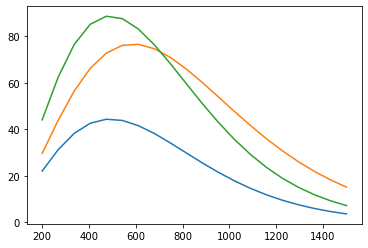

In [6]:
# The reference state
X = np.array([250, .5])
plt.plot(nu,greybody(nu,X))

# A different temperature
X = np.array([300, .5])
plt.plot(nu,greybody(nu,X))

# A different emissivity
X = np.array([250, 1])
plt.plot(nu,greybody(nu,X))

<font face="georgia">
Simulate an "observed spectrum"

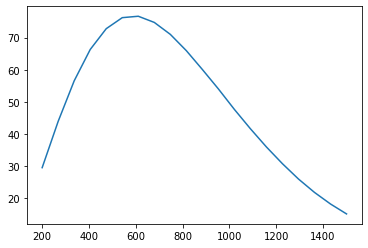

In [7]:
T = 300.                  # Temperature, K
Eps = .5                  # Emissivity
ErrLevelEst    = 0.1      # Estimate of noise level, RU
NoiseLevelTrue = 0.1      # RU
bias = 0.
noise = NoiseLevelTrue*np.random.randn(Nobs)
yobs  = (1e3*plancknu(nu,T) + noise + bias) * Eps

plt.plot(nu,yobs)

<font face="georgia">
Based on this "observed" spectrum, use inversion to get the best estimate for the cloud temperature and emissivity.

[294.88742172   0.46628455]
[300.53535715   0.49983248]
[299.91889972   0.50068808]
[299.9155703    0.50070485]
[299.91556656   0.50070487]


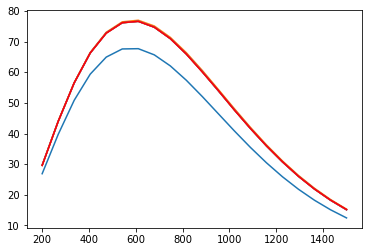

In [8]:
# .. A priori and statistics: 
#   note: X is temperature, emissivity, y is radiance at nu
Xa     = np.array([273., .8])              # a priori X
Xfg    = np.array([273., .8])              # first guess X
Sa_vec = np.array([3**2., 1.])             # variance for Xa
Se_vec = ErrLevelEst**2 * np.ones((Nobs))  # variance in measurement, y

# .. Set variables that won't change
Sa     = np.diag(Sa_vec)
Se     = np.diag(Se_vec)
inv_Sa = np.diag(1/Sa_vec);
yfg    = greybody(nu,Xfg)
yn_1   = yfg + 0.
Xn_1   = Xfg + 0.
dT     = .1
dEps   = .01
Kn     = np.ones((Nobs,2))                 # Weighting function
 
# .. Do the retrieval iteratively
Niters = 5                          # number of iterations
for iter in range(Niters):

    # .. Get kernels. Xp is the perturbed Xn_1
    #    Temperature, T
    Xp      = Xn_1 + 0.; Xp[0] += dT
    yp      = greybody(nu,Xp)
    Kn[:,0] = (yp - yn_1 ) / dT     # Temperature

    #     Emissivity, Eps
    Xp = Xn_1 + 0; Xp[1] += dEps
    yp = greybody(nu,Xp)
    Kn[:,1] = (yp - yn_1 ) / dEps
    
    # .. Invert as in Rodgers eqn. 5.9 (n-form)
    KT_Sem1   = ( solve(Se.T, Kn) ).T
    KT_Sem1_K = np.dot( KT_Sem1 , Kn )
      
    term2 = inv_Sa + KT_Sem1_K 
    term3 = np.dot( KT_Sem1 , ( yobs-yn_1 + np.dot(Kn,(Xn_1-Xa))  ) )
    Xn    = Xa + solve(term2, term3)
    
    yn    = greybody(nu,Xn)
    plt.plot(nu,yn)
    #plt.hold(True)
    
    # .. Set up for next iteration
    Xn_1 = Xn + 0.
    yn_1 = yn + 0.

    print (Xn)

plt.plot(nu,yobs,'r-')

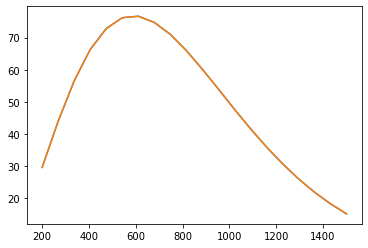

In [9]:
plt.plot(nu,yn,nu,yobs)

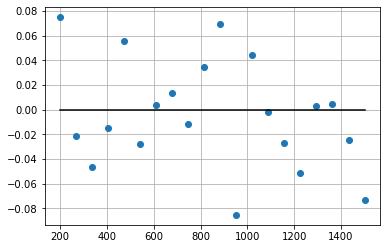

In [13]:
plt.plot(nu,yn-yobs,'o')
plt.plot([nu[0],nu[-1]],[0,0],'k-')
plt.grid()

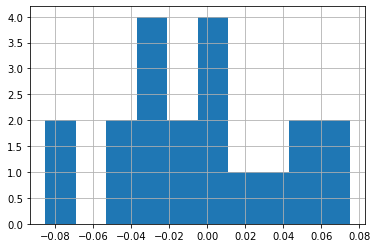

In [18]:
plt.hist(yn-yobs)
plt.grid()